# SoilTest Plot

<div align="left" style="width: 90%"><img src="info/logofiuba.png" width="150" align="right"/><img src="info/LogoSRK.jpeg" width="195" align="right" /></div>
<br>
<font style="font-family:sans-serif" color="grey" vspace="0.1em">
Coded by<br>
<hr style="margin:0.1em; solid lightgrey" width="90%" align="left" margin="0.5em">
<ul>
    <li>N. Tasso - <a href = "mailto: ntasso@srk.com.ar">ntasso@srk.com.ar</a> - <img src="info/Version.gif" > </li></ul>

<div class="alert alert-block alert-info">
<b>Usage</b><br>
<hr style="margin:0.1em; solid lightgrey" width="90%" align="left" margin="0.5em">
<ul>
    <li>Plot SoilTest's stress path</li>
</ul></div>
<div class="alert alert-block alert-warning">
<b>Input</b><br>
<hr style="margin:0.1em; solid lightgrey" width="90%" align="left" margin="0.5em">
<ul>
    <li>Soil parameters</li>
</ul></div>
<div class="alert alert-block alert-success">   
<b>Output</b><br>
<hr style="margin:0.1em; solid lightgrey" width="90%" align="left" margin="0.5em">
<ul>
    <li>GIF with stress path evolution in deviatoric plot, p vs q, q vs ea and tau vs sigma</li>
</ul>
</div>
</font>

<div style="color:#fff; font-size:16px; padding: 10px 36px; margin: 10px; background-color:#77d3e0; border: 1px solid #6cc8d4; -moz-border-radius: 5px; -webkit-border-radius: 5px; -khtml-border-radius: 5px; border-radius: 5px; width:660px;"><span style='font-weight:bold'>&#9432; #1 Before using the code: </span>This code uses FFmpeg software to create GIFs. Please download it from official page: https://ffmpeg.org/about.html</div>

## Libraries 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.notebook import tnrange    # Write "pip install tdqm" in anaconda prompt - https://pypi.org/project/tqdm/
from celluloid import Camera         # Write "pip install celluloid" in anaconda prompt - https://pypi.org/project/celluloid/
import matplotlib.animation as animation
import matplotlib.cbook as cbook
import matplotlib.image as image

## Plaxis lines

Configure the remote scripting server of SoilTest software

<img src="info/HowToConnect.png"/>

In [2]:
from plxscripting.easy import *
localhostport_input = 10000
s_s, g_s = new_server('localhost', localhostport_input, password='')

## Material parameters

In [28]:
E50_ref  = 3400   # Secant stiffness at 50% failure in standard drained triaxial test [kPa]
Eoed_ref = 9000   # Tangent stiffness for primary oedometer loading [kPa]
Eur_ref  = 60000  # Unloading/reloading stiffness from drained triaxial test [kPa]
nu       = 0.30   # Poisson's ratio for unloading/loading [-]
m        = 0.80   # Power of stress-level dependency of stiffness [-]
p_ref    = 100    # Reference stress for stiffness [kPa]
G0_ref   = 50000  # Reference shear modulus at very small strains (<10E-06) [kPa]
gamma_07 = 0.0001 # Threshold shear strain at which Gs = 0.722 * G0 [-]
c_ref    = 0      # Effective cohesion [kPa]
phi      = 30     # Effective angle of internal friction [deg]
psi      = 0      # Angle of dilatancy [deg]

# Test configuration

In [17]:
cellpressure = 100           # cell pressure [kPa]
behaviour    = 'undrained'   # drained | undrained
direction    = 'compression' # compression | extension
emax         = 5            # Maximum strain eyy
steps        = 500           # Number of steps

## Functions

### Yield surfaces in deviatoric plot

In [3]:
# Calculate corner points in MC failure surface
def supfalla(p,phi,c):
    sigma1lim=np.array([(c*np.cos(phi)-3*p*(np.sin(phi)/2-0.5))/(3/2-np.sin(phi)/2),
                        3*p/2-1/2*((c*np.cos(phi)-3*p/2*(np.sin(phi)/2-0.5))/(3/4+np.sin(phi)/4)),
                        3*p-2*((c*np.cos(phi)-3*p*(np.sin(phi)/2-0.5))/(3/2-np.sin(phi)/2)),
                        3*p/2-1/2*((c*np.cos(phi)-3*p/2*(np.sin(phi)/2-0.5))/(3/4+np.sin(phi)/4)),  
                        (c*np.cos(phi)-3*p*(np.sin(phi)/2-0.5))/(3/2-np.sin(phi)/2),
                        (c*np.cos(phi)-3*p/2*(np.sin(phi)/2-0.5))/(3/4+np.sin(phi)/4),
                      
                       (c*np.cos(phi)-3*p*(np.sin(phi)/2-0.5))/(3/2-np.sin(phi)/2),])
    
    sigma2lim=np.array([(c*np.cos(phi)-3*p*(np.sin(phi)/2-0.5))/(3/2-np.sin(phi)/2),
                        (c*np.cos(phi)-3*p/2*(np.sin(phi)/2-0.5))/(3/4+np.sin(phi)/4),
                        (c*np.cos(phi)-3*p*(np.sin(phi)/2-0.5))/(3/2-np.sin(phi)/2),
                        3*p/2-1/2*((c*np.cos(phi)-3*p/2*(np.sin(phi)/2-0.5))/(3/4+np.sin(phi)/4)),  
                        3*p-2*((c*np.cos(phi)-3*p*(np.sin(phi)/2-0.5))/(3/2-np.sin(phi)/2)),
                        3*p/2-1/2*((c*np.cos(phi)-3*p/2*(np.sin(phi)/2-0.5))/(3/4+np.sin(phi)/4)),
                      
                        
                       (c*np.cos(phi)-3*p*(np.sin(phi)/2-0.5))/(3/2-np.sin(phi)/2),])
    
    sigma3lim=np.array([3*p-2*((c*np.cos(phi)-3*p*(np.sin(phi)/2-0.5))/(3/2-np.sin(phi)/2)),
                        3*p/2-1/2*((c*np.cos(phi)-3*p/2*(np.sin(phi)/2-0.5))/(3/4+np.sin(phi)/4)),
                        (c*np.cos(phi)-3*p*(np.sin(phi)/2-0.5))/(3/2-np.sin(phi)/2),
                        (c*np.cos(phi)-3*p/2*(np.sin(phi)/2-0.5))/(3/4+np.sin(phi)/4),
                        (c*np.cos(phi)-3*p*(np.sin(phi)/2-0.5))/(3/2-np.sin(phi)/2),
                        3*p/2-1/2*((c*np.cos(phi)-3*p/2*(np.sin(phi)/2-0.5))/(3/4+np.sin(phi)/4)),
                       3*p-2*((c*np.cos(phi)-3*p*(np.sin(phi)/2-0.5))/(3/2-np.sin(phi)/2)),])
    
    xlim, ylim = deviatoriccoords(sigma1lim,sigma2lim,sigma3lim)
    return xlim, ylim

# Change of coordinates to deviatoric plane
def deviatoriccoords(sigma1,sigma2,sigma3):
    x = (sigma3-sigma2)*(1/np.sqrt(2))
    y = (1/np.sqrt(6))*(sigma1*2 -sigma3-sigma2)
    return x,y

## Triaxial

### SoilTest lines

Change soil parameters (only if HSS is used). If another model is used, this parameters can be changed manually

In [ ]:
g_s.Triaxial.CellPressure = cellpressure
g_s.Triaxial.MaximumStrain = emax
g_s.Triaxial.Steps = steps
g_s.Triaxial.Behaviour = behaviour
g_s.Triaxial.Direction = 'Compression'
g_s.Triaxial.Consolidation = 'Isotropic'

g_s.Material.E50Ref = E50_ref 
g_s.Material.EOedRef = Eoed_ref
g_s.Material.EURRef = Eur_ref
g_s.Material.nuUR = nu
g_s.Material.powerM = m
g_s.Material.pRef = p_ref
g_s.Material.G0Ref = G0_ref
g_s.Material.gamma07 = gamma_07
g_s.Material.cRef = c_ref
g_s.Material.phi = phi
g_s.Material.psi = psi


Calculate and extract data

In [4]:

g_s.calculate(g_s.Triaxial)

DATA = pd.DataFrame()
DATA['MeanEffStress'] = g_s.Triaxial.Results.MeanEffStress
DATA['SigmaEffective1'] = g_s.Triaxial.Results.SigmaEffective1
DATA['SigmaEffective2'] = g_s.Triaxial.Results.SigmaEffective2
DATA['SigmaEffective3'] = g_s.Triaxial.Results.SigmaEffective3
DATA['DeviatoricStress'] = g_s.Triaxial.Results.DeviatoricStress
DATA['Epsxx'] = g_s.Triaxial.Results.Epsxx
DATA['PExcess'] = g_s.Triaxial.Results.PExcess
DATA['TotalVolumetricStrain'] = g_s.Triaxial.Results.TotalVolumetricStrain


DATA['MeanEffStress'] = DATA['MeanEffStress']*-1
DATA['SigmaEffective1'] = DATA['SigmaEffective1']*-1
DATA['SigmaEffective2'] = DATA['SigmaEffective2']*-1
DATA['SigmaEffective3'] = DATA['SigmaEffective3']*-1
DATA['DeviatoricStress'] = DATA['DeviatoricStress']*1
DATA['PExcess'] = DATA['PExcess']*-1

### GIF

  0%|          | 0/101 [00:00<?, ?it/s]

C:\Users\ntasso\AppData\Roaming\Python\Python38\site-packages\matplotlib\animation.py:889: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you have outputted the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


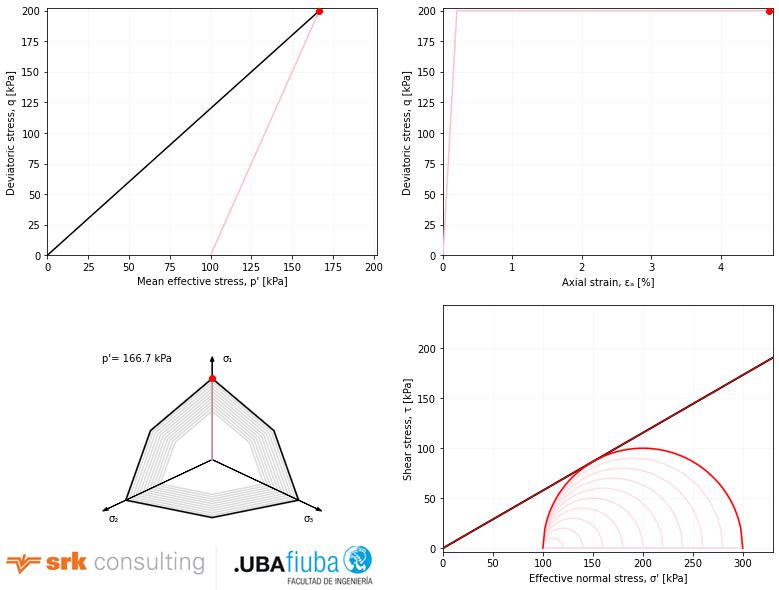

In [32]:

fig = plt.figure(figsize=(3.25*2*2,2.5*2*2))
fig.patch.set_facecolor('xkcd:white')

# Create four subplots
ax1 = fig.add_subplot(223) # 3D plot
ax2 = fig.add_subplot(221) # q-p plot
ax3 = fig.add_subplot(222) # q-e plot
ax4 = fig.add_subplot(224) # Mohr-Coulomb circles



# initialize some variables
camera = Camera(fig)
xline=[]
yline=[]
pexcessline = []
pline = []
epsline = []
qline= []
xfacum=[]
yfacum=[]
mohrpacks = []
mohrpackt = []

# Select maximum values in deviatoric coords
xs1, ys1 = deviatoriccoords(max(DATA['SigmaEffective1']*1.01),0,0)
xs2, ys2 = deviatoriccoords(0,max(DATA['SigmaEffective1']*1.01),0)
xs3, ys3 = deviatoriccoords(0,0,max(DATA['SigmaEffective1']*1.01))

# Define limits of plots according to data
ax1.axis([xs2*0.84*1.5,xs3*0.84*1.5,min(ys2,ys3)*1*1.5,ys1*0.84*1.5])
ax1.axis('off')
ax1.margins(0)
ax2.axis([0,max(max(DATA['MeanEffStress']*1.01),max(DATA['DeviatoricStress']*1.01)),0,max(max(DATA['MeanEffStress']*1.01),max(DATA['DeviatoricStress']*1.01))])
ax3.axis([0,max(DATA['Epsxx']*101),0,max(DATA['DeviatoricStress']*1.01)])
ax4.axis('equal')
ax4.set(xlim=(0,max(DATA['SigmaEffective1']*1.1)),ylim=(0,max(DATA['SigmaEffective1'])*0.8))


# Watermark. Please do not delete!
im = image.imread('info/logos.png')
fig.figimage(im, 0, 0, zorder=10)

# Take a 'picture' for every step in this for loop
for i in tnrange(len(DATA['MeanEffStress'])):
    
    # ----------------------------------
    # AX1 : 3D Plot
    # ----------------------------------
    # Names of axis
    ax1.text((xs3-xs2)*0.04,ys1*0.8,'\u03C3₁')
    ax1.text(xs3-(xs3-xs2)*0.15,min(ys2,ys3),'\u03C3₃')
    ax1.text(xs2+(xs3-xs2)*0.1025,min(ys2,ys3),'\u03C3₂')
    
    # Principal axis
    ax1.arrow(0,0,xs3*0.8,ys3*0.8,head_width=(-ys3/20),edgecolor='k',facecolor='k',zorder=20)
    ax1.arrow(0,0,xs2*0.8,ys2*0.8,head_width=(-ys3/20),edgecolor='k',facecolor='k',zorder=20)
    ax1.arrow(0,0,xs1*0.8,ys1*0.8,head_width=(-ys3/20),edgecolor='k',facecolor='k',zorder=20)
    
    # point and its stress path
    xspot,yspot = deviatoriccoords(DATA['SigmaEffective1'][i],DATA['SigmaEffective2'][i],DATA['SigmaEffective3'][i])
    xline = np.append(xline,xspot)
    yline = np.append(yline,yspot)
    ax1.plot(xline,yline, color='pink',zorder=120)
    ax1.scatter(xspot,yspot,color='r',zorder=130)

    # Failure surface and previous ones
    xf, yf = supfalla(DATA['MeanEffStress'][i],np.radians(phi),c_ref)
    ax1.plot(xf,yf,color='k', zorder=10)
    xfacum = np.append(xfacum,xf)
    yfacum = np.append(yfacum,yf)
    ax1.plot(xfacum,yfacum, color='gainsboro')

    # Mean effective stress text
    ax1.text(xs2+(xs3-xs2)*0.08,ys1*0.8,'p\'= '+str(np.round(DATA['MeanEffStress'][i],decimals=1))+' kPa')

    # ----------------------------------
    # AX2 : q-p Plot
    # ----------------------------------

    # Calculates Mtc
    Mtc = 6*np.sin(np.radians(phi))/(3-np.sin(np.radians(phi)))

    # Plot CSL line
    ax2.plot([0,max(DATA['MeanEffStress']*1.01)],[0,max(DATA['MeanEffStress'])*1.01*Mtc], color='k')

    # Plot data
    ppoint = DATA['MeanEffStress'][i]
    qpoint = DATA['DeviatoricStress'][i]
    pline= np.append(pline,ppoint)
    qline = np.append(qline,qpoint)
    ax2.plot(pline,qline, color='pink',zorder=120)
    ax2.scatter(ppoint,qpoint,color='r',zorder=130)

    # fancy settings
    ax2.set_xlabel('Mean effective stress, p\' [kPa]')
    ax2.set_ylabel('Deviatoric stress, q [kPa]')
    ax2.grid(color='whitesmoke')

    
    # ----------------------------------
    # AX2 : q-e Plot
    # ----------------------------------

    epspoint = DATA['Epsxx'][i]*100
    epsline= np.append(epsline,epspoint)
    ax3.plot(epsline,qline, color='pink',zorder=120)

    # fancy settings
    ax3.set_xlabel('Axial strain, \u03B5ₐ [%]')
    ax3.set_ylabel('Deviatoric stress, q [kPa]')
    ax3.grid(color='whitesmoke')
    ax3.scatter(epspoint,qpoint,color='r',zorder=130)

    # ----------------------------------
    # AX2 : Mohr circles
    # ----------------------------------

    # Radio and midpoint of circle
    radio = (DATA['SigmaEffective1'][i]-DATA['SigmaEffective3'][i])/2
    midpoint = (DATA['SigmaEffective1'][i]+DATA['SigmaEffective3'][i])/2

    # Mohr circles data
    mohrs = np.append(np.linspace(DATA['SigmaEffective1'][i],DATA['SigmaEffective3'][i],100),DATA['SigmaEffective3'].values[i])
    mohrt = np.sqrt(radio**2-(mohrs-midpoint)**2+0.00000000001)

    # Plot previous Mohr circles
    ax4.plot(mohrpacks,mohrpackt, color='pink',zorder=120, alpha=0.5)

    # Plot actual Mohr circle
    ax4.plot(mohrs,mohrt,color='r',zorder=130) 

    # Update Mohr circles packs 
    mohrpacks = np.append(mohrpacks,mohrs)
    mohrpackt = np.append(mohrpackt,mohrt)

    # Plot MC surface
    ax4.plot([0,10000],[0,10000*np.tan(np.radians(phi))], color='k', linewidth=2, zorder=125)

    # Plot tangent line
    phiact = np.arcsin((DATA['SigmaEffective1'][i]-DATA['SigmaEffective3'][i])/(DATA['SigmaEffective1'][i]+DATA['SigmaEffective3'][i]))
    ax4.plot([0,10000],[0,10000*np.tan(phiact)], color='r', linewidth=1, zorder=140)
    
    # fancy settings
    ax4.set_xlabel('Effective normal stress, σ\' [kPa]')
    ax4.set_ylabel('Shear stress, τ [kPa]')
    ax4.grid(color='whitesmoke')



    

    # take a frame
    camera.snap()
animationi = camera.animate()

fps = 20
Writer = animation.writers['ffmpeg']
writer3 = Writer(fps=fps, extra_args=['-r', '25'])
animationi.save('TRX CIUC - HSS model.gif', writer = writer3)